# The second experiment: use the cifar dataset to evaluate the trade-off power of different algorithms.

In [1]:
%load_ext autoreload
%autoreload 2
from lib.reduction_algorithms import EGDIS, POP, CL, WCL
from lib.callbacks import MonitorAndSaveParameters
from lib.data_loader import load_cifar10, load_cifar100
from keras.utils import to_categorical
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras

Using TensorFlow backend.


In [2]:
# init all four data reduction algorithms.
egdis = EGDIS()
pop = POP()
# CL needs the information about the dataset.
cl = CL()
wcl = WCL()

In [5]:
def show_tsne(x, y, classes):

#     return y
    tsne = TSNE(n_components=2, random_state=0, n_jobs=-1, n_iter=1500)
    intermediates_tsne = tsne.fit_transform(x)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=intermediates_tsne[:,0], y=intermediates_tsne[:,1],
        hue=y,
        palette=sns.color_palette("hls", classes),
        legend=None,
        alpha=0.3
    )
#     sns.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], hue=y)
    plt.show()
    
    return intermediates_tsne

In [59]:
def run_pop(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm POP")
    sample_weakness = pop.fit(x_train, y_train)
    sample_weakness = sample_weakness.astype(np.int64)
    fig = plt.figure(figsize=(15,5))
    ax = sns.countplot(sample_weakness, color="#3C76AF")
    ax.set_title("The distribution of the weakness")
    plt.show()
#     print("------------------ Start to select subsets ------------------")
#     subsets = []
#     for i in range(1, int(sample_weakness.max()+1)):
#         subset_idx = sample_weakness <= i
#         plot_y = y_train.copy()
#         plot_y[subset_idx] = classes
#         ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
#         ax.set_title("Selected samples with the POP algorithm with weakness <= {}".format(i))
#         plt.show()
#         subsets.append(subset_idx)
#     return subsets

In [7]:
def run_egdis(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm EGDIS with CIFAR.")
    selected_egdis_idx = egdis.fit(x_train, y_train)
    print("Selected {} samples".format(len(selected_egdis_idx)))
    plot_y = y_train.copy()
    plot_y[selected_egdis_idx] = classes
    ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
    ax.set_title("Samples selected by the EGDIS algorithm")
    plt.show()

    return selected_egdis_idx

In [8]:
def run_cl(x_train, y_train, classes, tsne):
    print("Now try to run the algorithm CL with CIFAR")
    cl.fit_dataset(classes=classes, dataset="cifar100")
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    selected_list = []
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        selected_x = x_train[selected_data_idx]
        selected_y = y_train[selected_data_idx]
        print("------------------ Start to select subsets ------------------")
        print("Selected {} percent training data.".format(i*10))
        
        plot_y = y_train.copy()
        plot_y[selected_data_idx] = classes
        ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
        
        ax.set_title("{} percent Samples selected by the CL algorithm".format(i*10))
        plt.show()
        selected_list.append(selected_data_idx)
    return selected_list, scores

In [9]:
def run_wcl(x_train, y_train, classes, tsne):
    print("Now try to run the WCL algorithm CL with CIFAR")
    wcl.fit_dataset(classes=classes, dataset="cifar100")
    scores, selected_boundary_idx = wcl.fit(x_train, y_train, classes)
    print("Selected {} boundary instances.".format(len(selected_boundary_idx)))
    plot_y = y_train.copy()
    plot_y[selected_boundary_idx] = classes
    ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
    ax.set_title("Selected {} boundary samples with EDGIS".format(len(selected_boundary_idx)))
    plt.show()
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        print("Select {:.2f} percent samples, {} overlapping with the pre-selected boundary samples".format(percent*100, len(np.intersect1d(selected_boundary_idx, selected_data_idx)))) 
    return scores, selected_boundary_idx

In [12]:
# load the compressed dataset
cifar100 = pd.read_csv(os.path.join("datasets", "cifar100", "compressed_train.csv")).values
cifar100_x = cifar100[:,:-100]
cifar100_y = cifar100[:,-100:]
cifar100_y = np.argmax(cifar100_y, axis=1)

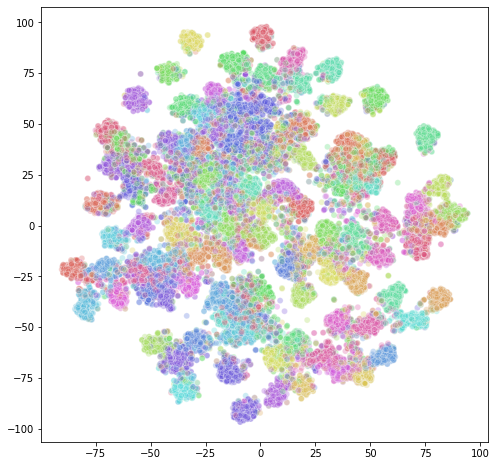

In [20]:
tsne_cifar100 = show_tsne(cifar100_x, cifar100_y, 100)

In [39]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## 1. Cifar10 

## 1.1 Cifar10 with POP

Now try to run the algorithm POP


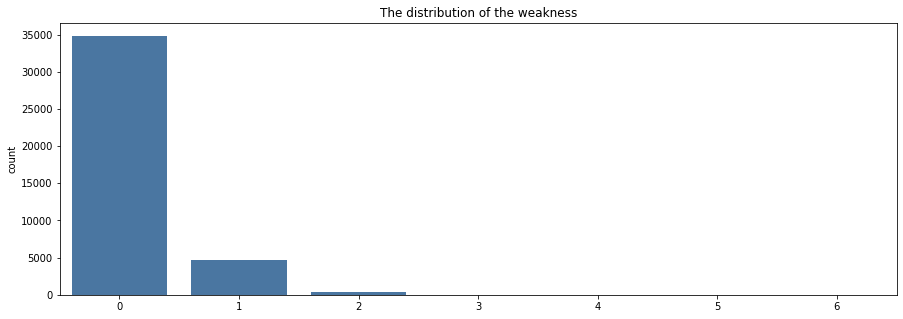

peak memory: 462.43 MiB, increment: 36.65 MiB
CPU times: user 2min 59s, sys: 1.57 s, total: 3min 1s
Wall time: 3min 4s


In [61]:
%time %memit  subsets = run_pop(cifar100_x, cifar100_y, 100, tsne_cifar100)

## 1.2 CIFAR10 with EGDIS

Now try to run the algorithm EGDIS with CIFAR.
Selected 14742 samples


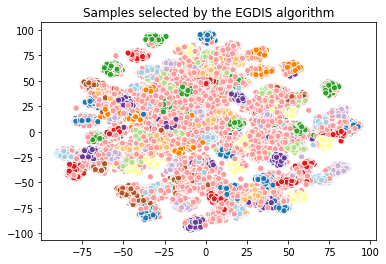

peak memory: 6978.45 MiB, increment: 6610.61 MiB
CPU times: user 32min 23s, sys: 2min 30s, total: 34min 54s
Wall time: 10min 9s


In [42]:
%time %memit selected_egdis_idx = run_egdis(cifar100_x, cifar100_y, 100, tsne_cifar100)

In [43]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar100", "selected_egdis_idx.npy"),selected_egdis_idx,allow_pickle=True)

## 1.3 CIFAR10 with CL

Now try to run the algorithm CL with CIFAR
Instructions for updating:
Please use `model.predict()` instead.
------------------ Start to select subsets ------------------
Selected 10 percent training data.


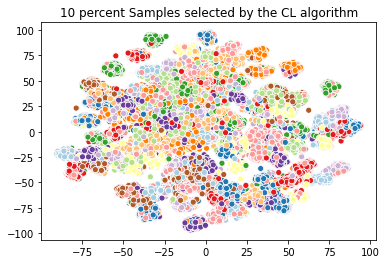

------------------ Start to select subsets ------------------
Selected 30 percent training data.


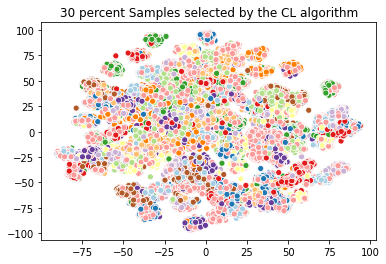

------------------ Start to select subsets ------------------
Selected 50 percent training data.


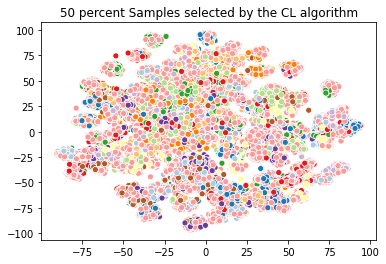

------------------ Start to select subsets ------------------
Selected 70 percent training data.


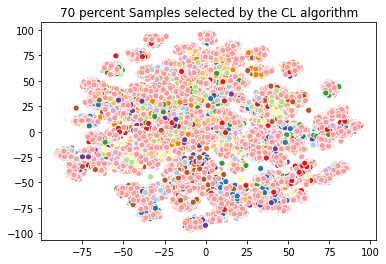

------------------ Start to select subsets ------------------
Selected 90 percent training data.


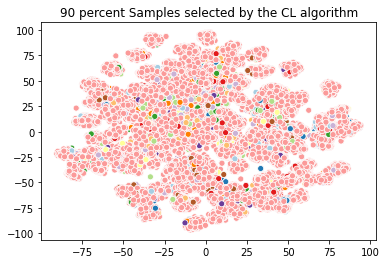

In [44]:
selected_list, scores = run_cl(cifar100_x, cifar100_y, 100, tsne_cifar100)

In [45]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar100", "cl_scores.npy"),scores,allow_pickle=True)

## 1.4 CIFAR with WCL

Now try to run the WCL algorithm CL with CIFAR
Selected 12258 boundary instances.


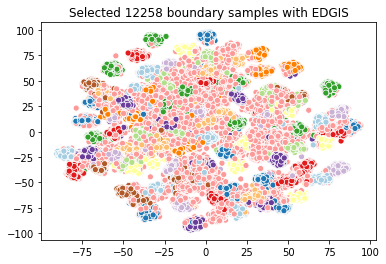

Select 10.00 percent samples, 454 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 1420 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 2843 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 4896 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 8830 overlapping with the pre-selected boundary samples
peak memory: 439.20 MiB, increment: 109.53 MiB
CPU times: user 11min 47s, sys: 3.49 s, total: 11min 50s
Wall time: 2min 1s


In [46]:
%time %memit scores, selected_boundary_idx = run_wcl(cifar100_x, cifar100_y, 100, tsne_cifar100)

In [47]:
np.save(os.path.join(os.getcwd(),  "datasets", "cifar100", "cl_boundary_idx.npy"),selected_boundary_idx,allow_pickle=True)

# 1.5 Scale up boundary scores to 1

In [48]:
selected_boundary_idx = np.load(os.path.join(os.getcwd(), "datasets", "cifar100", "cl_boundary_idx.npy"))
scores = np.load(os.path.join(os.getcwd(),  "datasets", "cifar100", "cl_scores.npy"))

In [49]:
y = cifar100_y[selected_boundary_idx]

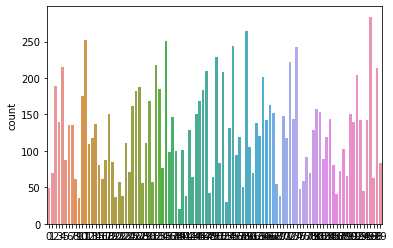

In [29]:
sns.countplot(y)

In [30]:
len(np.unique(y))

100

In [36]:
scores[selected_boundary_idx] = 1